In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, gamma as gamma_dist, beta as beta_dist, truncnorm, bernoulli, multinomial, norm

In [20]:
data_count = pd.read_csv("Deng_count.csv", index_col=0)
data_type = pd.read_csv("Deng_celltype.csv", index_col=0)
blast_cells = data_type[data_type['cell_type1'] == 'blast']
blast_counts = data_count.loc[:, blast_cells.index]

p_initial = (data_count == 0).mean(axis=1)
mu_initial = data_count[data_count > 0].mean(axis=1)

np.save("p_array.npy", p_initial.values)
np.save("mu_array.npy", mu_initial.values)

p = np.load("p_array.npy")

X = np.array(blast_counts.copy())

Z = np.zeros(np.shape(X)) 
p = np.load("p_array.npy")
mu = np.load("mu_array.npy")
Z_values = []
mu_values = []
p_values = []
alpha_p_values = []
beta_p_values = []
alpha_mu_values = []
beta_mu_values = []
alpha_g = np.zeros_like(mu)
alpha_g_values = []
lamb_values = []
individual_mu = np.zeros_like(X)
individual_mu_values = []

# Gibbs Sampling 
G = X.shape[0]
I = X.shape[1]
print(p)
print(np.shape(p))
print(mu)
print(np.shape(mu))
print(G)
print(np.shape(individual_mu))


[0.30970149 0.79104478 0.26492537 ... 0.75       0.84701493 0.15671642]
(11394,)
[388.44864865 326.89285714 982.81725888 ...  10.43283582  16.68292683
 342.09734513]
(11394,)
11394
(11394, 133)


In [3]:
def indicator_sampling(X, p, mu):
    G, I = X.shape
    non_zero_indices = np.where(X != 0)
    X_1 = X[non_zero_indices] * 0 
    p_extended = np.broadcast_to(p[:, np.newaxis], (G, I)) 
    mu_extended = np.broadcast_to(mu[:, np.newaxis], (G, I))  
    p = (1 - p_extended) * poisson.pmf(X, mu_extended)  
    p_complement = p_extended  
    normalized_p= np.stack([p, p_complement], axis=-1)  
    sum_p = np.sum(normalized_p, axis=2) 
    normalized_p = normalized_p / sum_p[..., np.newaxis] 
    samples = np.apply_along_axis(lambda p: np.random.choice([0, 1], p=p), -1, normalized_p)
    samples[non_zero_indices] = X_1
    return samples

In [4]:
def log_beta_dist(alpha_p, beta_p):
    if alpha_p <= 0 or beta_p <= 0:
        return -np.inf 
    log_hyperprior = -2.5 * np.log(alpha_p + beta_p) 
    log_likelihood = np.sum(beta_dist.logpdf(p, alpha_p, beta_p))
    log_posterior_pdf = log_hyperprior + log_likelihood
    return log_posterior_pdf

In [5]:
def metropolis_hastings_alpha_beta(iterations, initial_alpha_p, initial_beta_p, proposal_sd):
    samples = np.zeros((iterations, 2)) 
    current_alpha_p = initial_alpha_p
    current_beta_p = initial_beta_p

    current_posterior = log_beta_dist(current_alpha_p, current_beta_p) 

    for i in range(iterations):
        proposed_alpha_p = np.random.normal(current_alpha_p, proposal_sd)
        proposed_beta_p = np.random.normal(current_beta_p, proposal_sd)
        
        if proposed_alpha_p <= 0 or proposed_beta_p <= 0:
            samples[i] = [current_alpha_p, current_beta_p] 
            continue

        proposed_posterior = log_beta_dist(proposed_alpha_p, proposed_beta_p)
        acceptance_probability = np.exp(proposed_posterior - current_posterior)

        if acceptance_probability > np.random.rand():
            current_alpha_p = proposed_alpha_p
            current_beta_p = proposed_beta_p
            current_posterior = proposed_posterior

        samples[i] = [current_alpha_p, current_beta_p]

    return samples

In [6]:
def sampling_distribution_alpha_mu_beta_mu(alpha_mu, beta_mu, mu):
    c = 1/np.sqrt(G)
    lamb = 2/3
    log_alpha_mu_beta_mu = gamma_dist.logpdf(alpha_mu, c, scale=lamb)
    log_mu_given_alpha_mu_beta_mu = np.sum(gamma_dist.logpdf(mu, alpha_mu, scale=1/beta_mu))
    log_posterior = log_mu_given_alpha_mu_beta_mu + log_alpha_mu_beta_mu
    return log_posterior

In [7]:
def metropolis_hastings_alpha_mu_beta_mu(mu, initial_alpha_mu_beta_mu, iterations, proposal_std):
    samples = np.zeros((iterations, 2))
    current_alpha_mu, current_beta_mu = initial_alpha_mu_beta_mu
    
    current_logpdf = sampling_distribution_alpha_mu_beta_mu(current_alpha_mu, current_beta_mu, mu)
    
    for i in range(iterations):
        proposed_alpha_mu, proposed_beta_mu = np.random.normal([current_alpha_mu, current_beta_mu], proposal_std)

        if proposed_alpha_mu <= 0 or proposed_beta_mu <= 0:
            samples[i] = [current_alpha_mu, current_beta_mu]
            continue
        
        proposed_logpdf = sampling_distribution_alpha_mu_beta_mu(proposed_alpha_mu, proposed_beta_mu, mu)
        
        acceptance_prob = np.exp(proposed_logpdf - current_logpdf)

        
        if np.random.rand() < acceptance_prob:
            current_alpha_mu = proposed_alpha_mu
            current_beta_mu = proposed_alpha_mu
            current_logpdf = proposed_logpdf
            
        samples[i] = [current_alpha_mu, current_beta_mu]
    
    return samples

In [8]:
def sampling_distribution_lambda(alpha_g, lamb):
    log_exponential_sample = -1/np.sum(alpha_g) * lamb
    log_lambda = -lamb
    return log_exponential_sample + log_lambda

In [9]:
def metropolis_hastings_lambda(initial_lamb, initial_alpha_g, iterations, proposal_std):
    samples = np.zeros(iterations)
    current_lamb = initial_lamb

    current_logpdf = sampling_distribution_lambda(initial_alpha_g, current_lamb)
    
    for i in range(iterations):
        proposed_lamb = np.random.normal(current_lamb, proposal_std)

        if proposed_lamb <= 0:
            samples[i] = current_lamb
            continue
        
        proposed_logpdf = sampling_distribution_lambda(initial_alpha_g, proposed_lamb)
        
        acceptance_prob = np.exp(proposed_logpdf - current_logpdf)

        
        if np.random.rand() < acceptance_prob:
            current_lamb = proposed_lamb
            current_logpdf = proposed_logpdf
            
        samples[i] = current_lamb
    
    return samples

In [10]:
def sampling_distribution_alpha_g(alpha_g, mu, lamb):
    log_alpha_g_given_lambda = -lamb * alpha_g
    rate_alpha_g = mu / alpha_g 
    log_alpha_g_given_individual_mu = np.sum(gamma_dist.logpdf(mu, alpha_g, scale=1/rate_alpha_g))
    log_posterior = log_alpha_g_given_individual_mu + log_alpha_g_given_lambda
    return log_posterior

In [11]:
def metropolis_hastings_alpha_g(initial_alpha_g, mu, individual_mu, lamb, iterations, proposal_std):
    num_alpha_g = len(initial_alpha_g)
    samples = np.zeros((iterations, num_alpha_g))
    current_alpha_g = np.array(initial_alpha_g)
    
    current_logpdf = np.array([sampling_distribution_alpha_g(alpha, mu_val, lamb) for alpha, mu_val in zip(current_alpha_g, mu)])
    
    for i in range(iterations):
        for j in range(num_alpha_g):
            proposed_alpha_g = np.random.normal(current_alpha_g[j], proposal_std)

            if proposed_alpha_g <= 0:
                samples[i, j] = current_alpha_g[j]
                continue

            proposed_logpdf = sampling_distribution_alpha_g(proposed_alpha_g, mu[j], lamb)
            
            acceptance_prob = np.exp(proposed_logpdf - current_logpdf[j])
            
            if np.random.rand() < acceptance_prob:
                current_alpha_g[j] = proposed_alpha_g
                current_logpdf[j] = proposed_logpdf
            
            samples[i, j] = current_alpha_g[j]
    
    return samples

In [12]:
burn_in = 15

for i in range(100): 
    Z = indicator_sampling(X, p, mu)
    Z_values.append(Z)  # Assuming you might still want to analyze or visualize Z across all iterations

    # Metropolis-Hastings for alpha_p and beta_p
    initial_alpha_p = 1
    initial_beta_p = 1
    iterations = 250
    proposal_sd = 0.1
    list_beta_sampling = metropolis_hastings_alpha_beta(iterations, initial_alpha_p, initial_beta_p, proposal_sd)
    alpha_p = list_beta_sampling[iterations-1, 0]
    beta_p = list_beta_sampling[iterations-1, 1]

    # Metropolis-Hastings for alpha_mu and beta_mu
    initial_alpha_mu_beta_mu = [0.01, 10**(-4)]
    proposal_std = [0.01/10, 10**(-5)]
    iterations = 250
    samples = metropolis_hastings_alpha_mu_beta_mu(mu, initial_alpha_mu_beta_mu, iterations, proposal_std)
    alpha_mu = samples[iterations-1, 0]
    beta_mu = samples[iterations-1, 1]

    # Sampling for lambda
    initial_lamb = 0.01248
    proposal_std = 0.01248/10
    iterations = 250
    samples = metropolis_hastings_lambda(initial_lamb, initial_lamb, iterations, proposal_std)
    lamb = samples[iterations-1]

    # Sampling for alpha_g
    initial_alpha_g = np.full(G, 0.01248)
    proposal_std = 0.01248/10
    iterations = 150
    samples = metropolis_hastings_alpha_g(initial_alpha_g, mu, individual_mu, lamb, iterations, proposal_std)
    alpha_g = samples[iterations-1]
    
    # Update p_g
    for g in range(G):
        n = np.sum(Z[g, :] == 1)
        p[g] = np.random.beta(alpha_p + n, beta_p + I - n)

    # Update mu_g
    individual_mu_per_gene = np.sum(individual_mu, axis=1).reshape(-1, 1)
    epsilon = 1e-10  # Small number to ensure no division by zero
    for g in range(G):
        new_value = alpha_g[g] / (individual_mu_per_gene[g] + epsilon)
        mu[g] = np.random.gamma(alpha_mu + I*alpha_g[g], scale=1/(beta_mu + new_value))

    # Update mu_g_i
    alpha_g_extended = np.tile(alpha_g[:, np.newaxis], (1, I))
    mu_extended = np.tile(mu[:, np.newaxis], (1, I))
    individual_mu = np.random.gamma(alpha_mu + X, scale=1/((1 - Z) + alpha_g_extended/mu_extended))

    # Record values only after burn-in period
    if i >= burn_in:
        alpha_p_values.append(alpha_p)
        beta_p_values.append(beta_p)
        alpha_mu_values.append(alpha_mu)
        beta_mu_values.append(beta_mu)
        lamb_values.append(lamb)
        alpha_g_values.append(alpha_g)
        p_values.append(p.copy())  # Use copy to ensure that p is stored as at this iteration
        mu_values.append(mu.copy())
        individual_mu_values.append(individual_mu)

    print("Completed iteration", i)


C:\Users\darkr\AppData\Local\Temp\ipykernel_58816\1179830688.py:18: RuntimeWarning: overflow encountered in exp
  acceptance_prob = np.exp(proposed_logpdf - current_logpdf[j])


Completed iteration 0


C:\Users\darkr\AppData\Local\Temp\ipykernel_58816\155601728.py:16: RuntimeWarning: overflow encountered in exp
  acceptance_prob = np.exp(proposed_logpdf - current_logpdf)


Completed iteration 1


C:\Users\darkr\AppData\Local\Temp\ipykernel_58816\1080049136.py:17: RuntimeWarning: overflow encountered in exp
  acceptance_probability = np.exp(proposed_posterior - current_posterior)


Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40
Completed iteration 41
Completed iteration 42
Completed iteration 43
Completed iteration 44
Completed iteration

In [ ]:
# np.save('mu_values.npy', mu_values)        
# np.save('p_values.npy', p_values)       
# np.save('individual_mu_values.npy', individual_mu_values) 
# np.save('alpha_g_values.npy', alpha_g_values)  
# np.save('alpha_mu_values.npy', alpha_mu_values)         
# np.save('beta_mu_values.npy', beta_mu_values) 
# np.save('alpha_p_values.npy', alpha_p_values)         
# np.save('beta_p_values.npy', beta_p_values) 

In [21]:
mu_values = np.load('mu_values.npy')
p_values = np.load('p_values.npy')
individual_mu_values = np.load('individual_mu_values.npy')
alpha_g_values = np.load('alpha_g_values.npy')
alpha_mu_values = np.load('alpha_mu_values.npy')
beta_mu_values = np.load('beta_mu_values.npy')
alpha_p_values = np.load('alpha_p_values.npy')
beta_p_values = np.load('beta_p_values.npy')

mu = mu_values[-1]
p = p_values[-1]

[8.86866330e-02 5.42687688e-04 7.05402101e+02 ... 2.87820361e-02
 1.25186910e-08 7.90441043e+02]
(85, 11394)
(85, 11394)
(85, 11394)


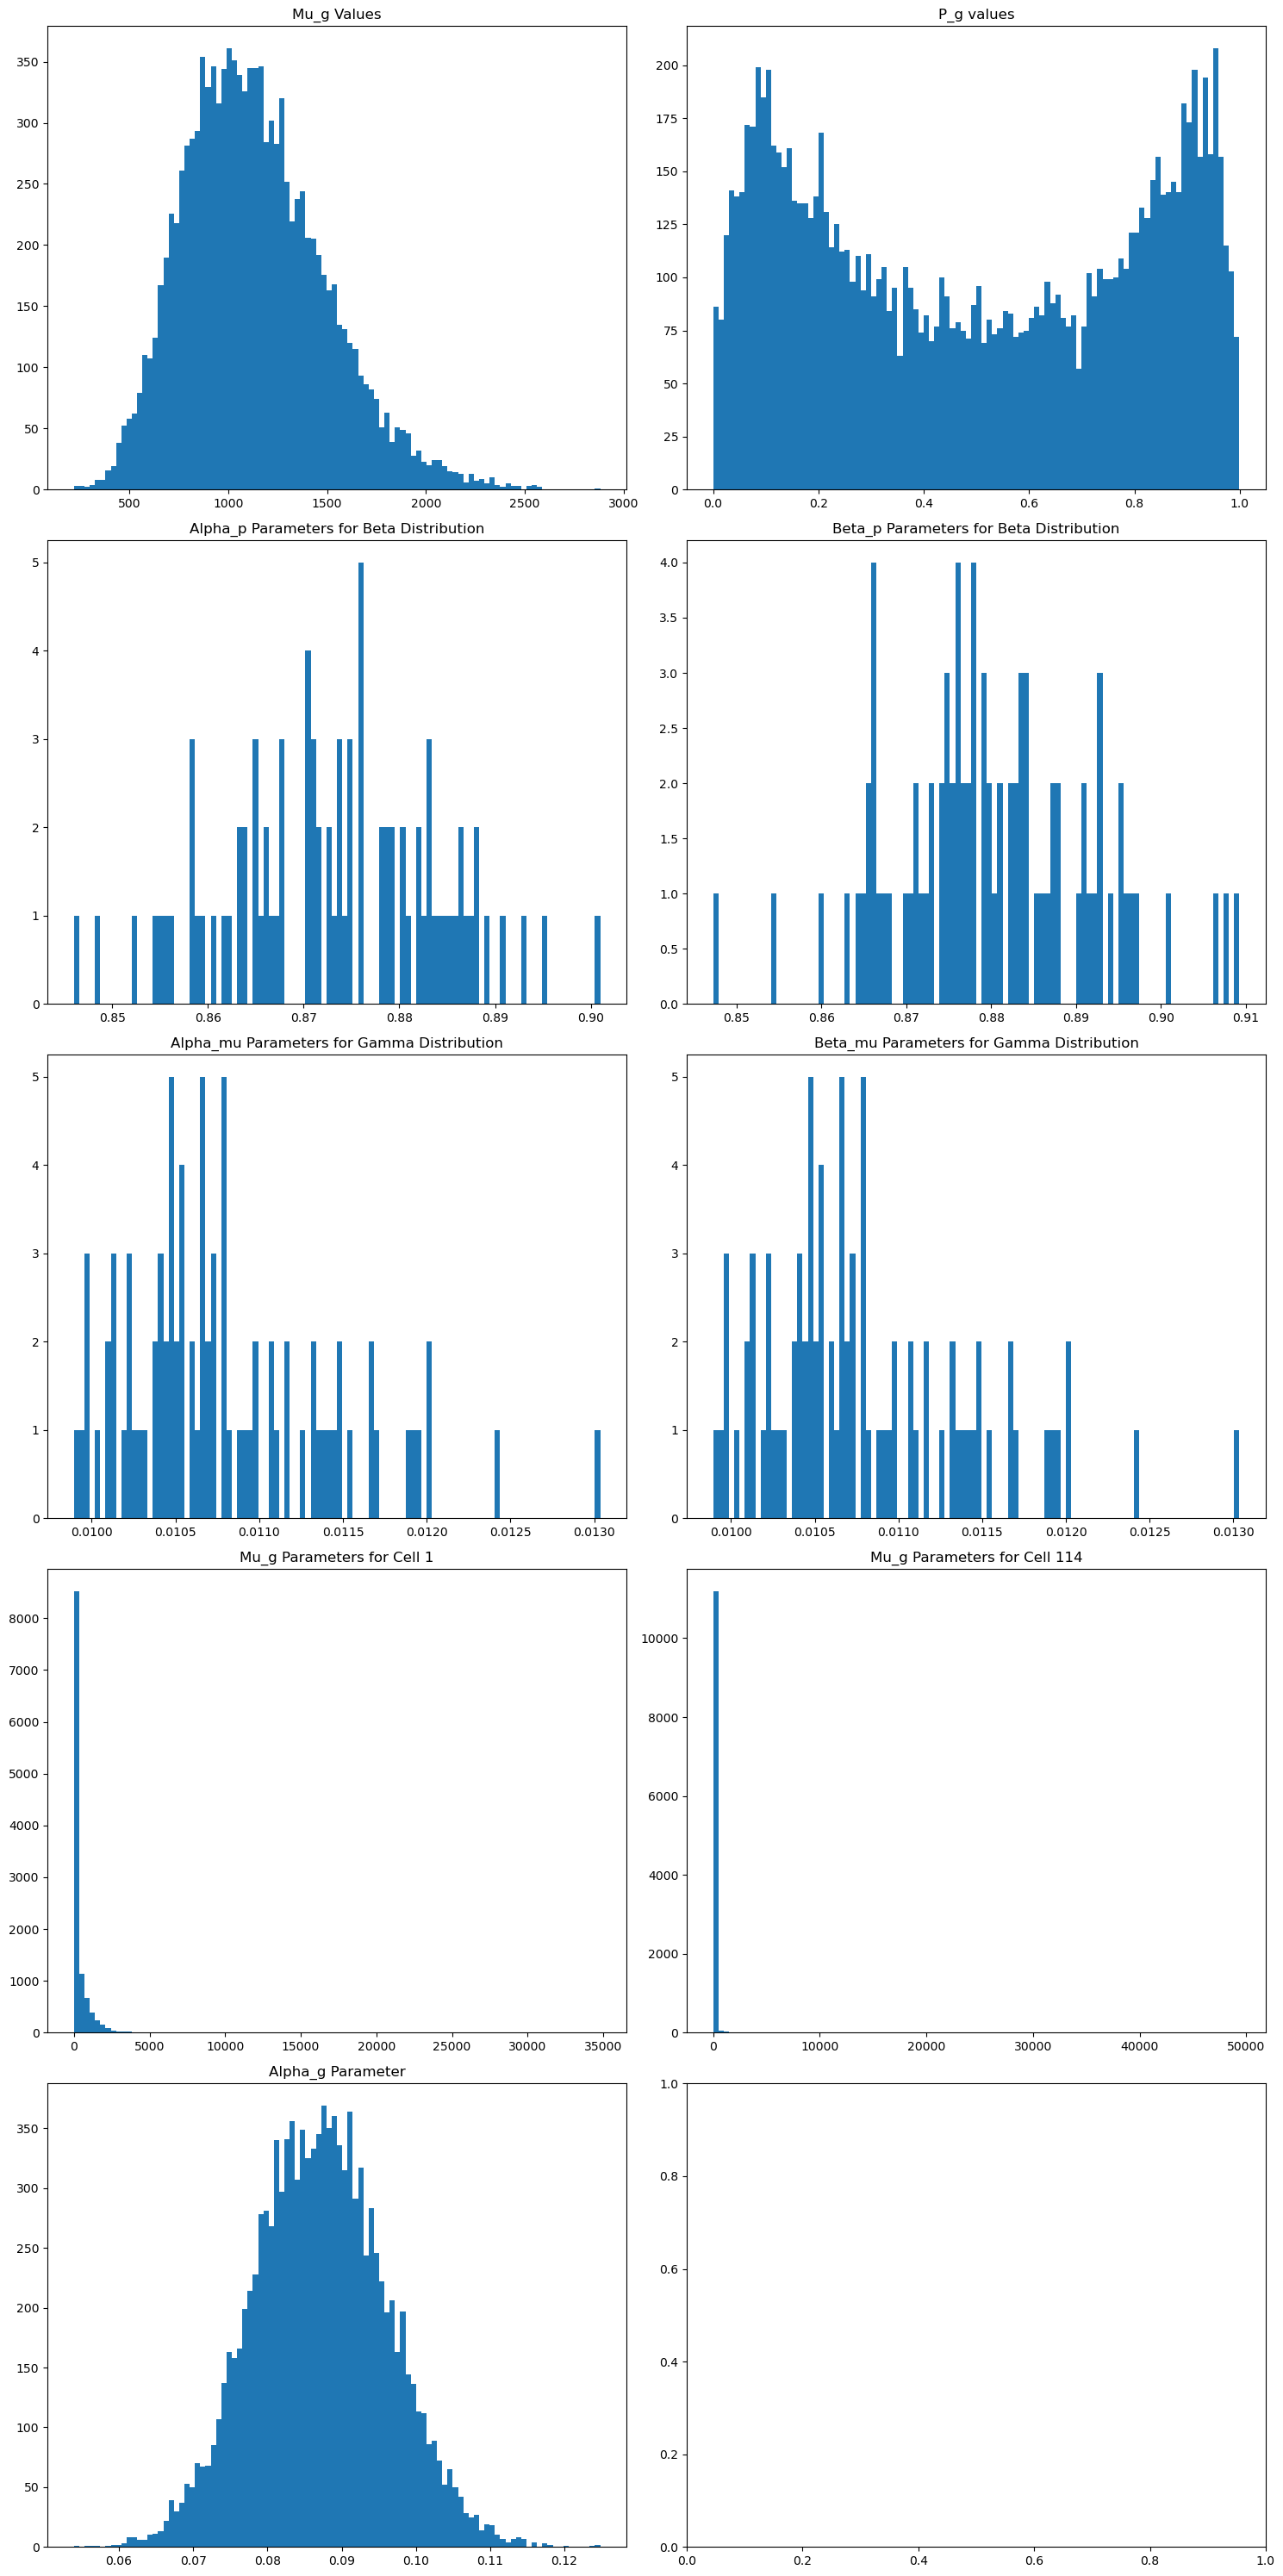

In [57]:
# print(mu_values)
# print(np.shape(mu_values))
# # print(individual_mu_values)
# print(np.shape(individual_mu_values))
# print(p_values)
# print(np.shape(p_values))
# print(alpha_p_values)
# print(beta_p_values)
# print(alpha_mu_values)
# print(beta_mu_values)
# print(alpha_g_values)

individual_mu_values = np.array(individual_mu_values)
alpha_g = alpha_g_values[-1]

print(individual_mu_values[:, :, 2][-1])
print(np.shape(individual_mu_values[:, :, 2]))
print(np.shape(mu_values))
print(np.shape(alpha_g_values))

fig, axs = plt.subplots(5, 2, figsize=(15, 30))
axs[0, 0].hist(mu, 100)
axs[0, 0].set_title("Mu_g Values")
axs[0, 1].hist(p, 100)
axs[0, 1].set_title("P_g values")
axs[1, 0].hist(alpha_p_values, 100)
axs[1, 0].set_title("Alpha_p Parameters for Beta Distribution")
axs[1, 1].hist(beta_p_values, 100)
axs[1, 1].set_title("Beta_p Parameters for Beta Distribution")
axs[2, 0].hist(alpha_mu_values, 100)
axs[2, 0].set_title("Alpha_mu Parameters for Gamma Distribution")
axs[2, 1].hist(beta_mu_values, 100)
axs[2, 1].set_title("Beta_mu Parameters for Gamma Distribution")
axs[3, 0].hist(individual_mu_values[:,:,0][-1], 100)
axs[3, 0].set_title("Mu_g Parameters for Cell 1")
axs[3, 1].hist(individual_mu_values[:,:,113][-1], 100)
axs[3, 1].set_title("Mu_g Parameters for Cell 114")
axs[4, 0].hist(alpha_g, 100)
axs[4, 0].set_title("Alpha_g Parameter")
plt.tight_layout()
plt.show()

In [42]:
print(f"Mean of mu: {np.mean(individual_mu_values)}")
print(f"Mean of p: {np.mean(p_values)}")
print(f"Mean of alpha_p: {np.mean(alpha_p_values)}")
print(f"Mean of beta p: {np.mean(beta_p_values)}")
print(f"Mean of alpha_mu: {np.mean(alpha_mu_values)}")
print(f"Mean of beta mu: {np.mean(beta_mu_values)}")
print(f"Mean of alpha g: {np.mean(alpha_g)}")

Mean of mu: 319.7196244136064
Mean of p: 0.49626869680041213
Mean of alpha_p: 0.8730942020218881
Mean of beta p: 0.8798560383392476
Mean of alpha_mu: 0.010805993037251613
Mean of beta mu: 0.010805993037251613
Mean of alpha g: 0.087121193885968


In [43]:
print(f"Standard Deviation of alpha_p: {np.std(alpha_p_values)}")
print(f"Standard Deviation of beta_p: {np.std(beta_p_values)}")
std_alpha_mu = np.std(alpha_mu_values)
print(f"Standard Deviation of alpha_mu: {std_alpha_mu}")
std_beta_mu = np.std(beta_mu_values)
print(f"Standard Deviation of beta_mu: {std_beta_mu}")
print(f"Standard Deviation of alpha_g: {np.std(alpha_g)}")

Standard Deviation of alpha_p: 0.011105682310531668
Standard Deviation of beta_p: 0.01151181700175366
Standard Deviation of alpha_mu: 0.0006137718049108866
Standard Deviation of beta_mu: 0.0006137718049108866
Standard Deviation of alpha_g: 0.008923476565689908


In [44]:
individual_mu = individual_mu_values[-1]
individual_mu = np.mean(individual_mu, axis = 1)

In [45]:
initial_data_mean = data_count.mean().mean()

initial_zero_probability = (data_count == 0).mean().mean()

def compute_posterior_predictive_stats(p, mu):
    predictive_mean = np.mean(individual_mu)
    predictive_zero_prob = np.mean(p)
    return predictive_mean, predictive_zero_prob

def check_convergence(p, mu, data_count, initial_data_mean, initial_zero_probability, tolerance_mean = 30, tolerance_prob=0.1):
    predictive_mean, predictive_zero_prob = compute_posterior_predictive_stats(p, mu)
    mean_diff = abs(predictive_mean - initial_data_mean)
    zero_prob_diff = abs(predictive_zero_prob - initial_zero_probability)
    print(f"The model's prediction for the mean is: {predictive_mean}")
    print(f"The model's prediction for the zero probability is: {predictive_zero_prob}")
    print(initial_data_mean)
    print(initial_zero_probability)
    if mean_diff < tolerance_mean and zero_prob_diff < tolerance_prob:
        print("Convergence likely achieved.")
        print(f"Predictive Mean Difference: {mean_diff}, Predictive Zero Probability Difference: {zero_prob_diff}")
    else:
        print("Convergence not yet achieved.")
        print(f"Predictive Mean Difference: {mean_diff}, Predictive Zero Probability Difference: {zero_prob_diff}")

check_convergence(p, individual_mu, data_count, initial_data_mean, initial_zero_probability)

The model's prediction for the mean is: 319.29968998169073
The model's prediction for the zero probability is: 0.49616771293295153
332.0669784961449
0.4643564038679693
Convergence likely achieved.
Predictive Mean Difference: 12.767288514454151, Predictive Zero Probability Difference: 0.03181130906498225


In [46]:
G = data_count.shape[0]
N0 = blast_counts.shape[1]

# Initial data mean
initial_data_mean = blast_counts.mean().mean()

# Probability that the data is 0
initial_zero_probability = (blast_counts == 0).mean().mean()

def compute_posterior_predictive_stats(p, mu):
    predictive_mean = np.mean(mu * (1 - p))
    predictive_zero_prob = np.mean(p + (1 - p) * np.exp(-mu))
    return predictive_mean, predictive_zero_prob

def check_convergence(p, mu, data_count, initial_data_mean, initial_zero_probability, tolerance_mean = 30, tolerance_prob=0.01):
    predictive_mean, predictive_zero_prob = compute_posterior_predictive_stats(p, mu)
    mean_diff = abs(predictive_mean - initial_data_mean)
    zero_prob_diff = abs(predictive_zero_prob - initial_zero_probability)
    print(f"The model's prediction for the mean is: {predictive_mean}")
    print(f"The model's prediction for the zero probability is: {predictive_zero_prob}")
    print(initial_data_mean)
    print(initial_zero_probability)
    if mean_diff < tolerance_mean and zero_prob_diff < tolerance_prob:
        print("Convergence likely achieved.")
        print(f"Predictive Mean Difference: {mean_diff}, Predictive Zero Probability Difference: {zero_prob_diff}")
    else:
        print("Convergence not yet achieved.")
        print(f"Predictive Mean Difference: {mean_diff}, Predictive Zero Probability Difference: {zero_prob_diff}")

last_slice = individual_mu_values[-1, :, :]
average_array = np.mean(individual_mu_values, axis=0)
row_means = np.mean(last_slice, axis=1)

check_convergence(p, row_means, data_count, initial_data_mean, initial_zero_probability)

The model's prediction for the mean is: 232.84580053646502
The model's prediction for the zero probability is: 0.4962858208669894
253.64257800900356
0.4962412613946663
Convergence likely achieved.
Predictive Mean Difference: 20.796777472538537, Predictive Zero Probability Difference: 4.455947232312463e-05
